# Análisis de los Datos del Corán

Este notebook contiene un análisis exploratorio de los datos del proyecto, incluyendo estadísticas descriptivas y visualizaciones para el Corán en árabe e inglés necesarias para la primera entrega del proyecto.

## Libererías necesarias.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")

## Empecemos!

Aqui cargamos el coran normalizado para evitar posibles ambiguedades

In [2]:
ar_q = pd.read_csv("../data/cleaned_data/cleaned_arab_quran.txt", 
                    sep="|", 
                    names=["Capítulo", "Versículo", "Texto"],
                    engine="python",
                    header=None)
ar_q["Capítulo"] = pd.to_numeric(ar_q["Capítulo"], errors="coerce")
ar_q.head()

,Capítulo,Versículo,Texto
0,1.0,1.0,بسم الله الرحمن الرحيم
1,1.0,2.0,الحمد لله رب العالمين
2,1.0,3.0,الرحمن الرحيم
3,1.0,4.0,مالك يوم الدين
4,1.0,5.0,اياك نعبد واياك نستعين


Estadísticas básicas

In [3]:
# Simplemente para ver el número de versos sin tener que eliminar los derechos de autor del dataset original
n_versos = len(ar_q["Texto"])
print(f"Número de versos antes de limpiar: {n_versos}")


ar_q = ar_q.dropna(subset=['Texto'])
ar_q = ar_q[ar_q['Texto'].str.strip() != '']

n_versos = len(ar_q["Texto"])
print(f"Número de versos después de limpiar: {n_versos}")

Número de versos antes de limpiar: 6264
Número de versos después de limpiar: 6236


In [4]:
n_capitulos = ar_q["Capítulo"].nunique()

print(f"Número de versos del Corán: {n_versos}.")
print(f"Número de capítulos del Corán: {n_capitulos}.")

ar_q["Número de palabras del verso"] = ar_q["Texto"].str.split().apply(lambda x: len(x) if isinstance(x, list) else 0)

n_palabras = ar_q["Número de palabras del verso"].sum()
promedio_palabras = ar_q["Número de palabras del verso"].mean()

print(f"Número total de palabras: {n_palabras}.")
print(f"Número promedio de palabras por verso: {round(promedio_palabras, 0)}.")

Número de versos del Corán: 6236.
Número de capítulos del Corán: 114.
Número total de palabras: 82627.
Número promedio de palabras por verso: 13.0.


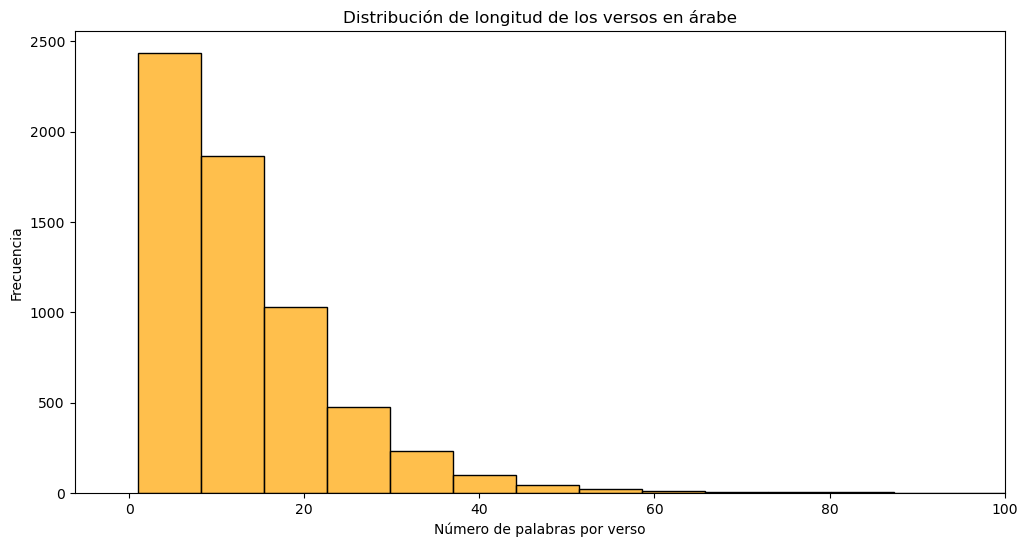

In [5]:
plt.figure(figsize=(12,6))
sns.histplot(ar_q["Número de palabras del verso"], bins=20, color="orange", alpha=.7)
plt.xlim(right=100)
plt.xlabel("Número de palabras por verso")
plt.ylabel("Frecuencia")
plt.title("Distribución de longitud de los versos en árabe")
plt.show()

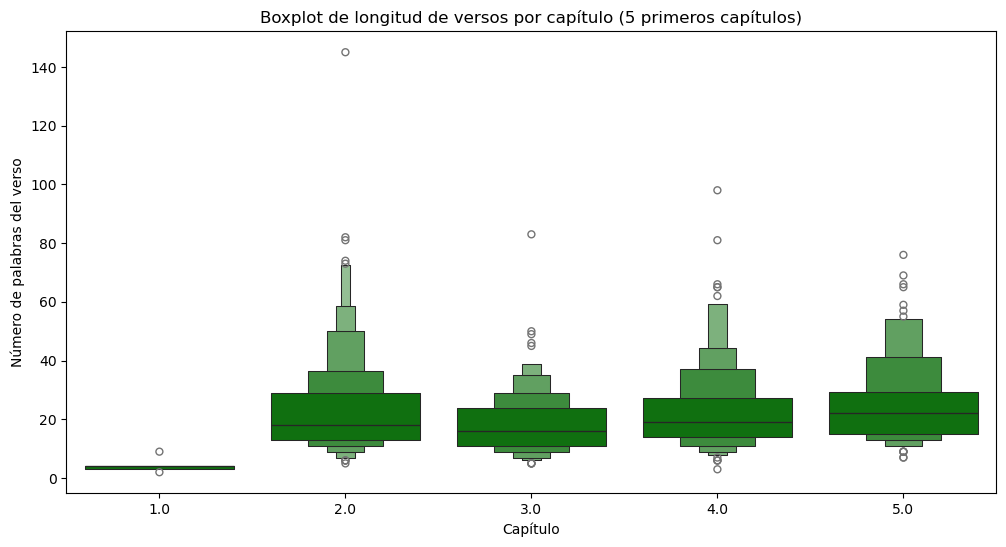

In [6]:
plt.figure(figsize=(12,6))
sns.boxenplot(x="Capítulo", y="Número de palabras del verso", data=ar_q[ar_q["Capítulo"] <= 5], color="green")
plt.title("Boxplot de longitud de versos por capítulo (5 primeros capítulos)")
plt.show()

## Camel_tools

Vamos a jugar un poco con camel_tools, una librería que hemos encontrado por chiripa y parece muy interesante.

Tareas:
- Probar a taggear las palabras y ver cuántas hay de cada una
- Mostrar las 10 palabras más comunes en árabe

A ver qué nos ofrece (https://camel-tools.readthedocs.io/en/latest/index.html)

In [7]:
from camel_tools.disambig.bert import BERTUnfactoredDisambiguator
from camel_tools.tagger.default import DefaultTagger
from camel_tools.tokenizers.word import simple_word_tokenize

In [8]:
texto = ar_q["Texto"].tolist()
tokens = []
for sentence in texto:
    tokens.extend(simple_word_tokenize(sentence))
print(len(tokens))

nltk.download('stopwords')
stop_words = set(stopwords.words('arabic'))
for token in tokens:
    if token in stop_words:
        tokens.remove(token)
print(len(tokens))

82627


[nltk_data] Downloading package stopwords to /home/unai-olaizola-
[nltk_data]     osa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


67176


## Analyzer (ya implicito) + BERT disambiguator

Aquí lo que nos interesa es descargar el morphological analyzer para analizar las palabras (que aunque no se llame a ninguna función suya el disambiguator lo usa por dentro) y el disambiguator para eliminar posibles ambigüedades en el significado.

In [9]:
#instalamos los modelos necesarios
!camel_data --install morphology-db-msa-r13
!camel_data --install disambig-bert-unfactored-msa

No new packages will be installed.
No new packages will be installed.


## Disambiguator

El disambiguator lo que hace es sacar el significado real de palabras que pueden tener más de un significado ya sea por polisemia o por la complejidad lexica del árabe.

In [10]:
batch_size = 2048

disambig = BERTUnfactoredDisambiguator.pretrained(model_name='msa')
print(len(tokens))

disambig_words = []
for i in range(0, len(tokens), batch_size):
    batch = tokens[i:i+batch_size]
    disambig_words.extend(disambig.disambiguate(batch))

print(len(disambig_words))
for d in disambig_words[:5]:
    best = d.analyses[0].analysis
    print(d.word, "→", best['lex'], "| POS:", best['pos'], "| Gloss:", best.get('gloss'))

Some weights of the model checkpoint at /home/unai-olaizola-osa/.camel_tools/data/disambig_bert_unfactored/msa were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


67176
67176
بسم → سَمّ | POS: noun | Gloss: by;with+poison+[def.gen.]
الله → اللَّه | POS: noun_prop | Gloss: Allah;God
الرحمن → رَحْمٰن | POS: adj | Gloss: the+merciful+[def.nom.]
الرحيم → رَحِيم | POS: adj | Gloss: the+compassionate+[def.nom.]
الحمد → حَمْد | POS: noun | Gloss: the+commendation;praise+[def.nom.]


## Pasos finales

Ahora guardamos los tokens ya desambigüados, normalizados, lematizados y sin stop words en la variable norm_tok ya que al coger la clave 'lex' del diccionario estaríamos obteniendo el lema o también conocido como la forma canónica del diccionario.

Ejemplo:
- "كَتَبَ", "كُتُب", "بالكتاب" → todos van a lex = "كتاب".

Y por otro lado en gloss_tok estamos guardando la glosa en ingles, que sería una traducción aproximada al inglés del árabe.

Con esto lo que finalmente tenemos es:
- No stop words
- Tokens normalizados y lematizados
- Tokens desambigüados
- Significado aproximado del token en inglés

In [11]:
norm_tok = [d.analyses[0].analysis['lex'] for d in disambig_words]
print(norm_tok[:10])
gloss_tok = [d.analyses[0].analysis['gloss'] for d in disambig_words]
print(gloss_tok[:10])

['سَمّ', 'اللَّه', 'رَحْمٰن', 'رَحِيم', 'حَمْد', 'اللَّه', 'رَبّ', 'عالَم', 'رَحْمٰن', 'رَحِيم']
['by;with+poison+[def.gen.]', 'Allah;God', 'the+merciful+[def.nom.]', 'the+compassionate+[def.nom.]', 'the+commendation;praise+[def.nom.]', 'to;for_God;Allah', 'lord;master+[def.nom.]', 'the+worlds+[masc.pl.]', 'the+merciful+[def.nom.]', 'the+compassionate+[def.nom.]']


## POS tagger

Aquí lo que hacemos es etiquetar gramaticalmente las palabras del Corán

In [12]:
pos_tagger = DefaultTagger(disambig, feature='pos')
pos_tags = pos_tagger.tag(norm_tok)

In [13]:
from collections import Counter
conteo = Counter(pos_tags)
print(conteo.most_common(10))

[('noun', 4637), ('verb', 3008), ('noun_prop', 1861), ('foreign', 1112), ('prep', 675), ('conj_sub', 623), ('adj', 616), ('conj', 251), ('part', 120), ('pron_rel', 103)]


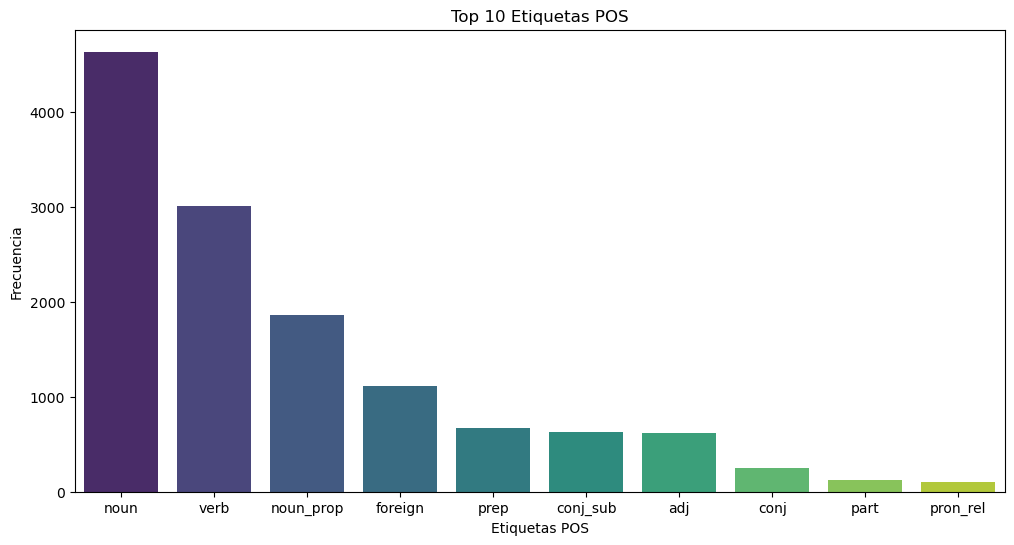

In [14]:
#Ploteamos las 10 etiquetas más comunes
plt.figure(figsize=(12,6))
etiquetas = [x[0] for x in conteo.most_common(10)]
frecuencias = [x[1] for x in conteo.most_common(10)]
sns.barplot(x=list(etiquetas), y=list(frecuencias), palette="viridis")
plt.xlabel("Etiquetas POS")
plt.ylabel("Frecuencia")
plt.title("Top 10 Etiquetas POS")
plt.show()

## Conteo de palabras

In [15]:
contar_palabras_arab = Counter(norm_tok)
contar_palabras_eng_gloss = Counter(gloss_tok)
print(contar_palabras_arab.most_common(10))
print(contar_palabras_eng_gloss.most_common(10))

[('أَنَّ', 2836), ('اللَّه', 2661), ('ۚ', 1972), ('ۖ', 1682), ('قال', 1480), ('عَلَى', 1239), ('كان', 1120), ('رَبّ', 954), ('إِلَى', 722), ('إِلّا', 703)]
[('NO_ANALYSIS', 2939), ('Allah;God', 2267), ('ۚ', 1972), ('that', 1696), ('ۖ', 1682), ('however;except', 702), ('on;above', 677), ('ۗ', 603), ('said+he;it_<verb>', 416), ('or', 402)]


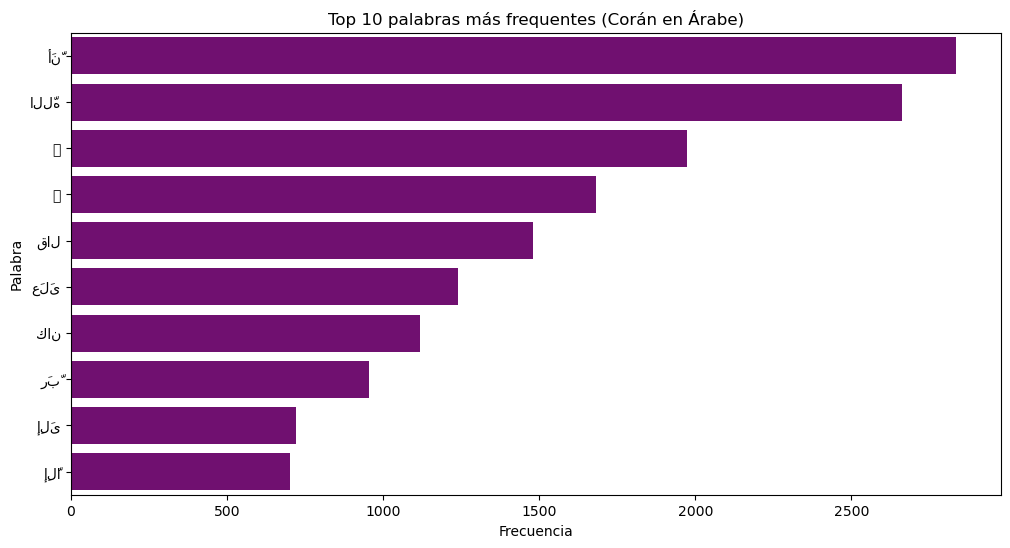

In [16]:
top10 = contar_palabras_arab.most_common(10)
palabras, frequencias = zip(*top10)

plt.figure(figsize=(12,6))
sns.barplot(x=list(frequencias), y=list(palabras), color="purple")
plt.title("Top 10 palabras más frequentes (Corán en Árabe)")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.show()

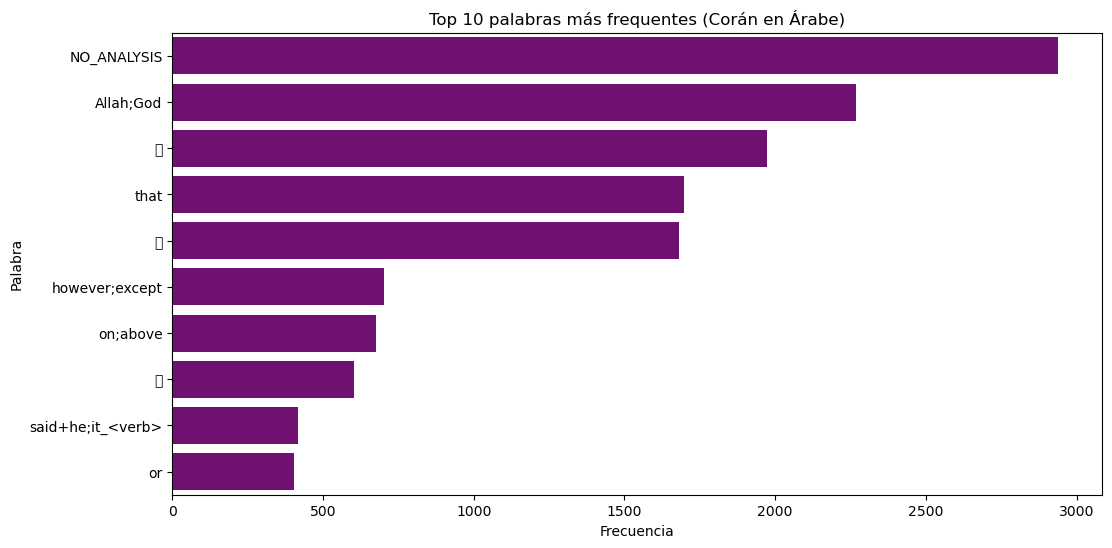

In [17]:
top10 = contar_palabras_eng_gloss.most_common(10)
palabras, frequencias = zip(*top10)

plt.figure(figsize=(12,6))
sns.barplot(x=list(frequencias), y=list(palabras), color="purple")
plt.title("Top 10 palabras más frequentes (Corán en Árabe)")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.show()

Como vemos arriba tenemos un problema con las stopwords en árabe y la limpieza de estas. Hay muchas stopwords en inglés que siguen apareciendo ya que las glosas no las filtran. También encontramos palabras que tienen NO_ANALYSIS que significa que el desambigüador no devolvió un análisis. Además hay otras etiquetas con signos de puntuación que hay que normalizar.

In [18]:
import re

en_stop_words = set(stopwords.words('english'))

def canon_gloss(g: str | None):
    if not g: 
        return None
    g = g.split(";")[0]
    g = g.split("+")[0]
    g = re.sub(r"\[.*?\]|\<.*?\>", "", g)
    g = g.strip().lower()
    # deja solo letras/espacios para evitar signos raros
    g = re.sub(r"[^a-z\s]", "", g).strip()
    return g or None

rows = []
no_analysis = 0
for dw in disambig_words:
    if not dw.analyses or dw.analyses[0].analysis.get("gloss") == "NO_ANALYSIS":
        no_analysis += 1
        continue
    best = dw.analyses[0].analysis
    if best.get("pos") == "punc":
        continue
    gloss = canon_gloss(best.get("gloss"))
    if not gloss:
        continue
    if gloss in en_stop_words:
        continue
    rows.append(gloss)

print("NO_ANALYSIS descartados:", no_analysis)
freq_gloss = Counter(rows)
top10_gloss = freq_gloss.most_common(10)
top10_gloss

NO_ANALYSIS descartados: 2939


[('allah', 2267),
 ('theypeople', 1738),
 ('lord', 881),
 ('said', 730),
 ('however', 706),
 ('arrive', 361),
 ('insure', 309),
 ('say', 273),
 ('something', 267),
 ('day', 246)]

Volvemos a probar a plotear a ver qué sale.

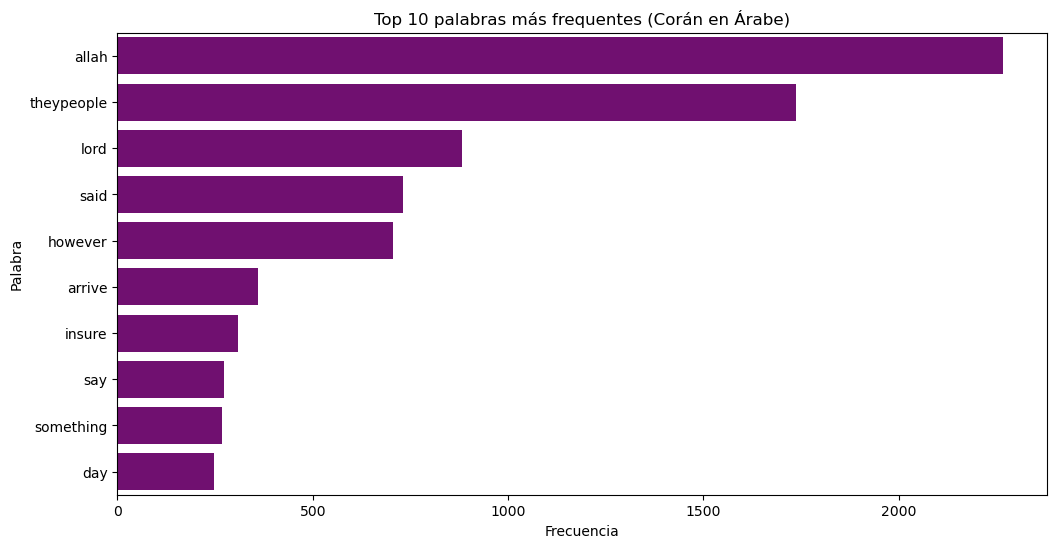

In [19]:
top10_gloss = freq_gloss.most_common(10)
palabras, frequencias = zip(*top10_gloss)

plt.figure(figsize=(12,6))
sns.barplot(x=list(frequencias), y=list(palabras), color="purple")
plt.title("Top 10 palabras más frequentes (Corán en Árabe)")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.show()

Ahora vamos a hacer exactamente lo que hemos hecho con el árabe pero en inglés para comparar si efectivamente el disambiguator y todo funciona correctamente.

[nltk_data] Downloading package stopwords to /home/unai-olaizola-
[nltk_data]     osa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


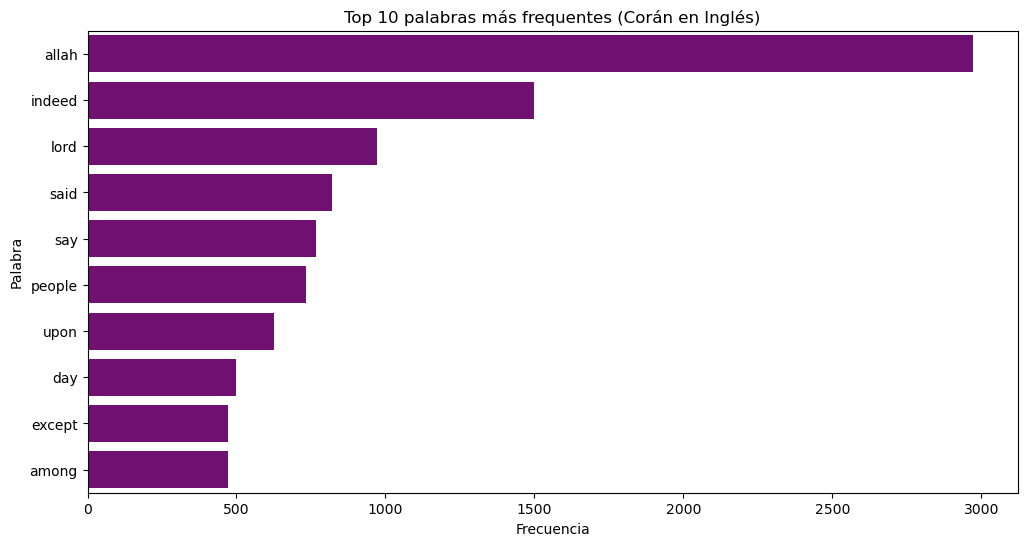

In [20]:
eng_q = pd.read_csv('../data/raw_data/english_quran.txt', 
                    sep="|", 
                    names=["Capítulo", "Verso", "Texto"],
                    engine="python",
                    quoting=3, # Necesario para evitar problemas con las comillas en el texto en inglés.
                    header=None)
eng_q["Capítulo"] = pd.to_numeric(eng_q["Capítulo"], errors="coerce")
eng_q.head()

palabras = " ".join(eng_q["Texto"].dropna()).split()

# Para una representación más filedigna, vamos a obviar los stopwords
nltk.download("stopwords")
stopwords_eng = set(stopwords.words("english"))

palabras_sin_sw = [
    p.lower().strip(string.punctuation)  # quita comas, puntos, ... 
    for p in eng_q["Texto"].dropna().str.split().sum()
    if p.lower().strip(string.punctuation) not in stopwords_eng and p.lower().strip(string.punctuation) != ""
]
frequencia_palabra = Counter(palabras_sin_sw)

top10 = frequencia_palabra.most_common(10)

palabras, frequencias = zip(*top10)

plt.figure(figsize=(12,6))
sns.barplot(x=list(frequencias), y=list(palabras), color="purple")
plt.title("Top 10 palabras más frequentes (Corán en Inglés)")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.show()

Parece que si, las primeras 10 palabras mas comunes coinciden casi en su totalidad. Asi que podemos concluir que hemos limpiado correctamente el texto en árabe de manera que se puede traducir bastante bien y que los metodos de desambiguación, tokenización y normalización efectivamente funcionan.

## TF - IDF (Update de la entrega 2) 
Por último, vamos a probar el método TF-IDF para estudiar más a fondo el análisis de las palabras. Haremos plot de las 10 palabras en cada idioma con mayor valor en el término TF-IDF.

In [21]:
vectorizer_ar = TfidfVectorizer(lowercase=False,
                                max_df=.85, # ignorar palabras que aparecen en más del 85% de los documentos
                                min_df=2, # ignorar palabras que aparecen en menos de 2 documentos
                                ngram_range=(1,1), # sólo queremos unigramas
                                max_features=10000)
vectorizer_eng = TfidfVectorizer(lowercase=True,
                                 stop_words='english', # en inglés sí que existe la opción de eliminar stopwords
                                 max_df=.85,
                                 min_df=2,
                                 ngram_range=(1,1),
                                 max_features=10000) 

X_ar = vectorizer_ar.fit_transform(ar_q["Texto"].dropna())
X_eng = vectorizer_eng.fit_transform(eng_q["Texto"].dropna())

Ahora crearemos una función para escoger las 10 palabras com mayor TF-IDF:

In [22]:
def top_10_TFIDF(X, vectorizer):
    suma_documentos = np.array(X.sum(axis=0)).flatten()
    df = pd.DataFrame({
        "palabra": vectorizer.get_feature_names_out(),
        "tfidf": suma_documentos
    })
    return df.sort_values(by="tfidf", ascending=False).head(10)

top_10_ar = top_10_TFIDF(X_ar, vectorizer_ar)
top_10_eng = top_10_TFIDF(X_eng, vectorizer_eng)

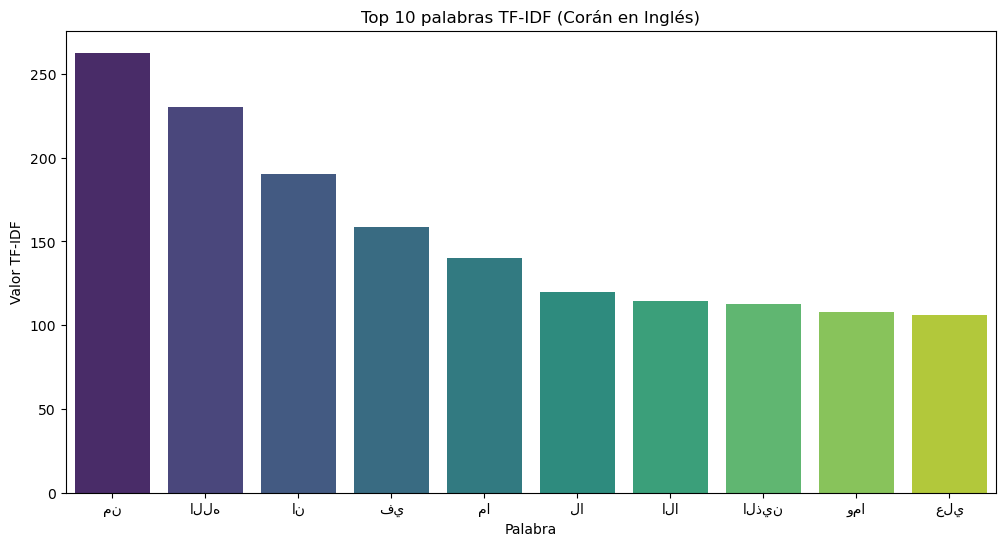

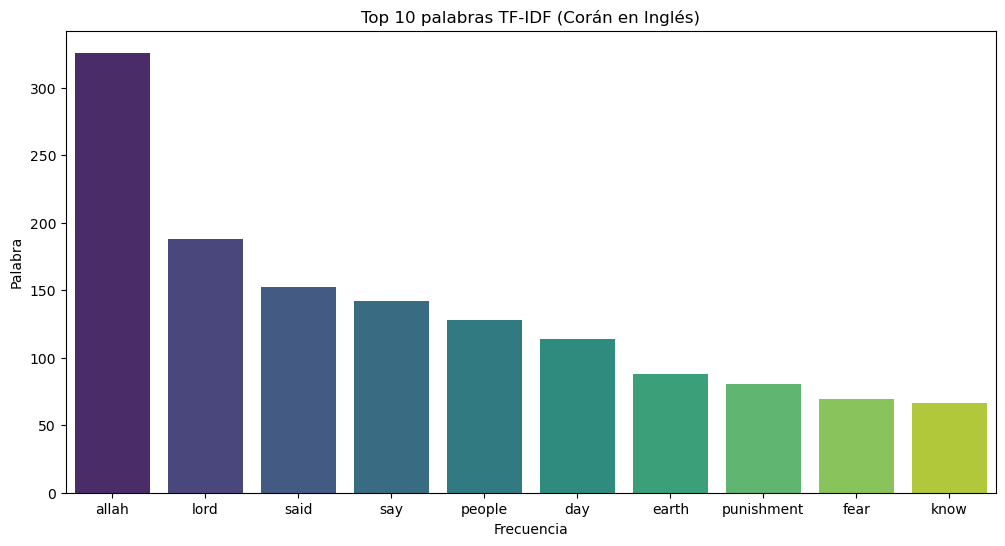

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x=top_10_ar["palabra"], y=top_10_ar["tfidf"], palette="viridis")
plt.title("Top 10 palabras TF-IDF (Corán en Inglés)")
plt.xlabel("Palabra")
plt.ylabel("Valor TF-IDF")
plt.show() 

plt.figure(figsize=(12,6))
sns.barplot(x=top_10_eng["palabra"], y=top_10_eng["tfidf"], palette="viridis")
plt.title("Top 10 palabras TF-IDF (Corán en Inglés)")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.show()

plt.tight_layout()
plt.show()

Aún así, no podemos concluir que las 10 palabras con mayor TF-IDF sean idénticas, ya que no contamos con la traducción de las palabras en árabe. Para eso, usaremos el proceso impolementado en la anterior entrega:

In [26]:
mapping_gloss = dict(zip(norm_tok, gloss_tok))
top_10_ar["gloss"] = top_10_ar["palabra"].map(mapping_gloss)
print(top_10_ar[["palabra", "gloss", "tfidf"]])

     palabra        gloss       tfidf
4237      من  NO_ANALYSIS  262.882739
904     الله          NaN  230.172092
1128      ان          NaN  190.241632
3402      في          NaN  158.591330
3974      ما         what  139.980099
3669      لا   and+no;not  120.091347
457      الا          NaN  114.171857
657    الذين  NO_ANALYSIS  112.612317
5263     وما          NaN  108.028655
2937     علي          NaN  106.215164
